# Fitting a Gaussian Process to USGS Bathymetry Data

In [2]:
# All imports here...

# Numpy and linear algebra libraries
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import progressbar
import imp
from multiprocessing import Process, Value, Array

import csv

import tensorly as tl
import itertools

import TensorToolbox.multilinalg as mla
import TensorToolbox as DT
from TensorToolbox.core import STT
import SpectralToolbox
from sklearn.externals.joblib import Parallel, delayed

import gaussian_process as GP

Using mxnet backend.
/Users/Vivek/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Plotting data...


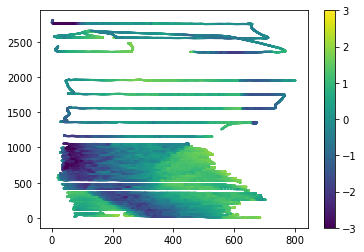

In [4]:
FILENAME = 'data/usgs_bath_data/capstone_data_sample.csv'
data=[]
meanHeight = 0

# Angle to rotate the river data by
ROT_ANGLE = 0.13 * np.pi

# Rotate to align river with axes
ROT_MATRIX = np.array([
        [np.cos(ROT_ANGLE), -np.sin(ROT_ANGLE),  0],
        [np.sin(ROT_ANGLE),  np.cos(ROT_ANGLE),  0],
        [0,                  0,                  1]
        ], dtype=float)

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}

cm = matplotlib.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

def import_data():
    global data
    with open(FILENAME) as csvfile:
        filereader = csv.reader(csvfile, delimiter=',')
        header = True
        for row in filereader:
            if header:
                header = False
            else:
                data.append([float(row[1]), float(row[2]), float(row[4])])

    data = np.array(data, dtype=float)
    data = data.transpose()

def preprocess(data):
    '''
    Translate / rotate the data, normalize it so that it has mean 0.
    :param data:
    :return:
    '''
    global meanHeight
    data[0, :] -= min(data[0, :])
    data[1, :] -= min(data[1, :])
    meanHeight = np.mean(data[2, :])
    data[2, :] -= meanHeight

def plotData(data, colors):
    print("Plotting data...")
    plt.figure()
    plt.scatter(data[0, :], data[1, :], c = colors, s = 1, vmin=-3, vmax=3)
    plt.colorbar()
    # plt.show()
    # print("Plotting complete.")

import_data()
data = np.matmul(ROT_MATRIX, data)
preprocess(data)
plotData(data, data[2, :])
plt.show()

### Gaussian Process w/ simple subset-of-data approximation

In [117]:
imp.reload(GP)

sf = 0.3
scaledData = data * sf

# Build the Gaussian process (using the homemade GaussianProcess class)
sampleSize = 1600
gp = GP.GaussianProcess('RBF', 1000)
sample = np.random.permutation(data.transpose())[:sampleSize]

print("Building Gaussian Process...")
gp.build_sd(sample[:, 0:2], sample[:, 2:3], 0.9)
print("Built Gaussian Process...")

Building Gaussian Process...
Itr: 17
Built Gaussian Process...


### GP with Induced Inputs (Requires Clustering)

Building Gaussian Process...
Itr: 566
Built Gaussian Process...


### Querying from the Gaussian Process

100% (5000 of 5000) |####################| Elapsed Time: 0:08:32 Time:  0:08:32

Plotting data...
Plotting data...


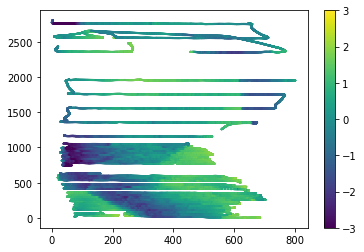

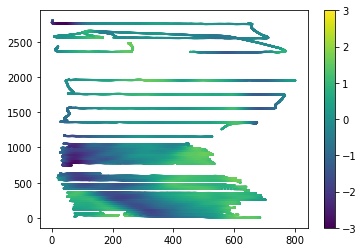

0.28241967196644896


In [142]:
# Query the GP; we can use multithreading to do this efficiently...
predMeans = Array('f', len(data.transpose()))

threads = []
numThreads = 20
threadWidth = 5000
dt = data.transpose()

def threadFunc(tid, predMeans):
    for i in progressbar.progressbar(range(threadWidth)):
        predMeans[tid * threadWidth + i] = gp.query(dt[tid * threadWidth + i, 0:2])[0]

# For convenience, work exclusively with the first m points in the dataset
for i in range(numThreads):
    threads.append(Process(target=threadFunc, args=(i,predMeans)))
    threads[-1].start()
    
for t in threads:
    t.join()
    
plotData(data[:, 0:threadWidth * numThreads], data[2, 0:threadWidth * numThreads])
plotData(data[:, 0:threadWidth * numThreads], predMeans[0:threadWidth * numThreads])
plt.show()
    
# Get the mean-squared error

mse = np.sqrt((la.norm(data[2, 0:threadWidth * numThreads] - predMeans[0:threadWidth * numThreads]) ** 2) / (threadWidth * numThreads))
print(mse)

In [128]:
# Get the RMSE

mse = np.sqrt((la.norm(data[2, 0:threadWidth * numThreads] - predMeans[0:threadWidth * numThreads]) ** 2) / (threadWidth * numThreads))
print(mse)

0.28241967196644896


### Clustering the input data for induced input locations

In [38]:
imp.reload(GP)

centers = GP.lloydKMeans(data.transpose()[:, 0:2], 100, 25)

100% (25 of 25) |########################| Elapsed Time: 0:30:47 Time:  0:30:47

Plotting data...


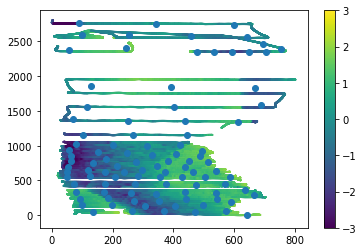

In [39]:
plotData(data, data[2, :])
plt.scatter(centers[:, 0], centers[:, 1])
plt.show()

In [105]:
# Training Gaussian Process on the clusters...

imp.reload(GP)

print("Training GP...")
process = GP.GaussianProcess('RBF', 14000)
process.build_ii(data.transpose()[:, 0:2], data.transpose()[:, 2:3].transpose(), 0.85, 100, None, Xbar=centers[:100])
print("GP Trained...")

Training GP...
GP Trained...


### Approximating the GP Using a Spectral Tensor Train Decomposition

In [166]:
# Use spectral tensor train to approximate the mean function

subdivs = 120
xRange = 800.0
yRange = 3000.0
grid = [np.arange(-1, xRange, (xRange + 1) / subdivs), np.arange(-1, yRange, (yRange + 1) / subdivs)]

approximation = STT(lambda X, params: gp.query(X)[0], grid, params=0, surrogateONOFF = True, surrogate_type='LinearInterpolation')

res = approximation.build()

In [165]:
pt=np.array([500, 200])

print(approximation.__call__(pt))
print(gp.query(pt))

/Users/Vivek/anaconda/lib/python3.6/site-packages/SpectralToolbox/Spectral1D/LagrangePolynomials.py:169: RuntimeWarning: invalid value encountered in double_scalars
  T[k,j] = T[k,j] / s


ValueError: array must not contain infs or NaNs

-0.29060933079752127